## 학습

In [2]:
from pandas import DataFrame
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation,Flatten
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import model_from_json
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.
/Users/xiilab/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/xiilab/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/xiilab/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/xiilab/anaconda3/lib/python3.7/site-packages/t

Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
df = pd.read_csv('./trainval_data.csv')
df.head(3)

,datetime,temperature,humidity,usage,weekday
0,2019-01-02 00:00:00,0.0,23.9,40.412,2
1,2019-01-02 00:15:00,-0.9,27.0,40.412,2
2,2019-01-02 00:30:00,-1.5,28.5,40.412,2


In [4]:
def minmax_scaler(X, minmax_range):
    scaled = (X - minmax_range[0]) / (minmax_range[1] - minmax_range[0])
    return scaled


def create_dataset(data, data2,look_back=192):
    dataX, dataY = [], []
    for i in range(len(data)-2*look_back):
        dataX.append(data[i:(i+look_back)])
        dataY.append(data2[i+2*(look_back)])
    return np.array(dataX), np.array(dataY)


In [5]:
df = df.interpolate(method='linear', limit_direction='both', axis=0)

train_set = df.iloc[:int(len(df)*0.8)]
test_set = df.iloc[int(len(df)*0.8):]

print(f'전체 데이터 : {len(df)}')
print(f'학습 데이터 : {len(train_set)}')
print(f'시험 데이터 : {len(test_set)}')

전체 데이터 : 25163
학습 데이터 : 20130
시험 데이터 : 5033


In [5]:
pw = np.array(train_set['usage'])
pw = pw.reshape(pw.shape[0],1)
temp = np.array(train_set['temperature'])
temp = temp.reshape(temp.shape[0],1)
humd = np.array(train_set['humidity'])
humd = humd.reshape(humd.shape[0],1)
wday = np.array(train_set['weekday'])
wday = wday.reshape(wday.shape[0],1)

pw = minmax_scaler(pw, [min(pw), max(pw)])
temp = minmax_scaler(temp, [-40,40])
humd = minmax_scaler(humd, [0,100])
wday = minmax_scaler(wday, [0,6])

total = np.hstack([pw,temp,humd,wday])
X_train, y_train = create_dataset(total,pw)

print(X_train.shape)
print(y_train.shape)

model = Sequential()
model.add(LSTM(32,input_shape=(X_train.shape[1],4),return_sequences=True))
model.add(LSTM(32,input_shape=(X_train.shape[1],4)))
# model.add(TimeDistributed(Dense(1)))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=384, verbose=2, shuffle=False)

from keras.models import model_from_json

model_json = model.to_json()
jsonname = 'lstm_model.json'
h5name = 'lstm_model.h5'
with open(jsonname,"w") as json_file:
    json_file.write(model_json)

model.save_weights(h5name)
print("Saved model to disk")
print('finished!')    

(19746, 192, 4)
(19746, 1)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
 - 43s - loss: 0.1504
Epoch 2/50
 - 40s - loss: 0.1354
Epoch 3/50
 - 35s - loss: 0.1244
Epoch 4/50
 - 36s - loss: 0.1169
Epoch 5/50
 - 41s - loss: 0.1210
Epoch 6/50
 - 48s - loss: 0.1215
Epoch 7/50
 - 38s - loss: 0.1191
Epoch 8/50
 - 38s - loss: 0.1224
Epoch 9/50
 - 35s - loss: 0.1203
Epoch 10/50
 - 35s - loss: 0.1177
Epoch 11/50
 - 35s - loss: 0.1153
Epoch 12/50
 - 36s - loss: 0.1121
Epoch 13/50
 - 37s - loss: 0.1128
Epoch 14/50
 - 40s - loss: 0.1088
Epoch 15/50
 - 43s - loss: 0.1138
Epoch 16/50
 - 42s - loss: 0.1090
Epoch 17/50
 - 39s - loss: 0.1115
Epoch 18/50
 - 45s - loss: 0.1052
Epoch 19/50
 - 43s - loss: 0.1188
Epoch 20/50
 - 45s - loss: 0.1033
Epoch 21/50
 - 43s - loss: 0.1146
Epoch 22/50
 - 44s - loss: 0.1037
Epoch 23/50
 - 41s - loss: 0.1059
Epoch 24/50
 - 43s - loss: 0.1031
Epoch 25/50
 - 45s - loss: 0.1041
Epoch 26/50


### 테스트

In [6]:
def inverse_scaler(X,minmax_range):
    inv = X * (minmax_range[1]-minmax_range[0]) + minmax_range[0]
    return inv

In [7]:
pw_range = [min(df['usage']), max(df['usage'])]
pw = np.array(test_set['usage'])
pw = pw.reshape(pw.shape[0],1)

temp = np.array(test_set['temperature'])
temp = temp.reshape(temp.shape[0],1)
humd = np.array(test_set['humidity'])
humd = humd.reshape(humd.shape[0],1)
wday = np.array(test_set['weekday'])
wday = wday.reshape(wday.shape[0],1)

pw = minmax_scaler(pw, pw_range)
temp = minmax_scaler(temp, [-40,40])
humd = minmax_scaler(humd, [0,100])
wday = minmax_scaler(wday, [0,6])

Test = np.hstack([pw,temp,humd,wday])

json_file = open('lstm_model.json',"r")
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights('lstm_model.h5')
model.compile(loss='mse', optimizer='adam')

predictions = []
y_test = []

i = 0; cnt = 0
while (i < len(Test)-384):
    X_test, test_y = create_dataset(Test[i:i+385],pw[i:i+385],192)
    pred = model.predict(X_test)
    print(pred, end=' ')
    predictions.append(pred)
    y_test.append(test_y)

    i += 1
    cnt += 1
##### inverse transform ##############
y_test = inverse_scaler(np.array(y_test),pw_range)
predictions = inverse_scaler(np.array(predictions),pw_range)
y_test = np.vstack(y_test).squeeze()
predictions = np.vstack(predictions).squeeze()


Instructions for updating:
Colocations handled automatically by placer.


[[0.54845786]] [[0.52157414]] [[0.4911109]] [[0.4674112]] [[0.4390888]] [[0.41461936]] [[0.39576843]] [[0.37029788]] [[0.34728235]] [[0.31960055]] [[0.28320265]] [[0.24923077]] [[0.22017282]] [[0.19376129]] [[0.17631164]] [[0.15888706]] [[0.14350563]] [[0.12889323]] [[0.11358635]] [[0.10050917]] [[0.08962046]] [[0.08220493]] [[0.07729114]] [[0.07760907]] [[0.08058216]] [[0.07863513]] [[0.07643051]] [[0.07487364]] [[0.07308902]] [[0.07170403]] [[0.07121421]] [[0.07727048]] [[0.08238792]] [[0.0827342]] [[0.08264389]] [[0.08104847]] [[0.07994092]] [[0.07823666]] [[0.08045039]] [[0.08866767]] [[0.08858182]] [[0.08704791]] [[0.08454761]] [[0.08230541]] [[0.08054445]] [[0.07977151]] [[0.08813101]] [[0.0942039]] [[0.09527852]] [[0.09749951]] [[0.1076435]] [[0.11957297]] [[0.12958626]] [[0.13082159]] [[0.13626844]] [[0.13521086]] [[0.13017237]] [[0.13660881]] [[0.1652295]] [[0.1935848]] [[0.2183798]] [[0.23784812]] [[0.25165448]] [[0.25734797]] [[0.25048608]] [[0.24033616]] [[0.23151141]] [[0.

[[0.6535479]] [[0.64307016]] [[0.6418891]] [[0.66378266]] [[0.6936901]] [[0.7254904]] [[0.7344547]] [[0.7289019]] [[0.71929187]] [[0.70477927]] [[0.69488937]] [[0.68429995]] [[0.6712481]] [[0.65641403]] [[0.6395304]] [[0.6422616]] [[0.6266842]] [[0.6022681]] [[0.5714946]] [[0.543531]] [[0.5241419]] [[0.5089959]] [[0.4900705]] [[0.47896385]] [[0.45146888]] [[0.43851086]] [[0.41930193]] [[0.4020299]] [[0.3822291]] [[0.3472749]] [[0.3162186]] [[0.2876105]] [[0.27012604]] [[0.24443412]] [[0.22337905]] [[0.20284244]] [[0.18450728]] [[0.1688647]] [[0.15282148]] [[0.13929096]] [[0.130533]] [[0.1209586]] [[0.11046398]] [[0.10213669]] [[0.0964919]] [[0.09299663]] [[0.09109299]] [[0.09033828]] [[0.09740031]] [[0.09908583]] [[0.09631253]] [[0.0926791]] [[0.0901508]] [[0.08795497]] [[0.08696998]] [[0.08712771]] [[0.09603127]] [[0.09873139]] [[0.09869585]] [[0.09921086]] [[0.09957033]] [[0.10109338]] [[0.10316907]] [[0.11631805]] [[0.12299159]] [[0.12551893]] [[0.12652567]] [[0.14018203]] [[0.14659

[[0.32309356]] [[0.32029164]] [[0.31474018]] [[0.3088003]] [[0.30124488]] [[0.29589865]] [[0.28844225]] [[0.2795543]] [[0.27015355]] [[0.2633649]] [[0.2547346]] [[0.2450977]] [[0.23362723]] [[0.22419293]] [[0.21684916]] [[0.21719731]] [[0.21571496]] [[0.21110068]] [[0.20750493]] [[0.20354669]] [[0.2000206]] [[0.19570953]] [[0.19324534]] [[0.19074735]] [[0.18993104]] [[0.19036263]] [[0.18930256]] [[0.18763012]] [[0.18517363]] [[0.1826202]] [[0.18074095]] [[0.18239424]] [[0.18009514]] [[0.17802079]] [[0.17595252]] [[0.17349085]] [[0.17129505]] [[0.17130661]] [[0.16976011]] [[0.16755098]] [[0.16499808]] [[0.16157822]] [[0.15842861]] [[0.15609378]] [[0.149347]] [[0.14162374]] [[0.13470101]] [[0.12772182]] [[0.12126337]] [[0.11460277]] [[0.10907175]] [[0.10578586]] [[0.09903233]] [[0.09235033]] [[0.08691072]] [[0.08166993]] [[0.07779585]] [[0.07789342]] [[0.07561176]] [[0.07269268]] [[0.07186293]] [[0.07129692]] [[0.07058262]] [[0.07207093]] [[0.07482687]] [[0.07396792]] [[0.07198082]] [[0.

[[0.1479809]] [[0.14915517]] [[0.14841938]] [[0.15049817]] [[0.16117956]] [[0.18442571]] [[0.20018707]] [[0.21566941]] [[0.2360163]] [[0.2574226]] [[0.27366078]] [[0.33800244]] [[0.43867457]] [[0.5364008]] [[0.626906]] [[0.6922553]] [[0.73165387]] [[0.7605796]] [[0.7601139]] [[0.7573816]] [[0.7540288]] [[0.74873734]] [[0.74155295]] [[0.7477679]] [[0.7680553]] [[0.7829705]] [[0.7851435]] [[0.79459107]] [[0.79049516]] [[0.7790043]] [[0.7723714]] [[0.769074]] [[0.76761985]] [[0.7704604]] [[0.7529412]] [[0.7300833]] [[0.725241]] [[0.7082511]] [[0.68948376]] [[0.6763047]] [[0.6527947]] [[0.6324513]] [[0.61234164]] [[0.6001429]] [[0.57848996]] [[0.55511814]] [[0.5332929]] [[0.5196523]] [[0.5007373]] [[0.4771302]] [[0.45000204]] [[0.42671388]] [[0.40107894]] [[0.38191128]] [[0.3612788]] [[0.33906436]] [[0.31486195]] [[0.29264227]] [[0.27459237]] [[0.25505564]] [[0.22964703]] [[0.20359519]] [[0.17630246]] [[0.15226966]] [[0.13545528]] [[0.1212828]] [[0.11561517]] [[0.11444639]] [[0.1070554]] [

[[0.08468317]] [[0.08968399]] [[0.08963145]] [[0.08705955]] [[0.08525596]] [[0.08362173]] [[0.08580145]] [[0.09459256]] [[0.09585743]] [[0.09375283]] [[0.09117229]] [[0.0893029]] [[0.0893158]] [[0.09288827]] [[0.09314726]] [[0.09258532]] [[0.09311171]] [[0.09599131]] [[0.10124329]] [[0.10560535]] [[0.10893951]] [[0.11624213]] [[0.12570447]] [[0.13322543]] [[0.14055414]] [[0.1471406]] [[0.16085172]] [[0.18868253]] [[0.21337017]] [[0.22914614]] [[0.23716985]] [[0.23981082]] [[0.24150643]] [[0.23826182]] [[0.23490368]] [[0.23349544]] [[0.23016936]] [[0.22681598]] [[0.22860126]] [[0.22781438]] [[0.2253926]] [[0.22354087]] [[0.22648923]] [[0.22675529]] [[0.22198123]] [[0.21692313]] [[0.21313053]] [[0.21124052]] [[0.21142949]] [[0.2094114]] [[0.20807785]] [[0.20783113]] [[0.20911188]] [[0.20806256]] [[0.20522916]] [[0.20159796]] [[0.20185718]] [[0.20210212]] [[0.20048851]] [[0.19795603]] [[0.1961986]] [[0.19869131]] [[0.19682384]] [[0.19740456]] [[0.19566007]] [[0.19449675]] [[0.19313565]] [

[[0.29812977]] [[0.26809692]] [[0.24029185]] [[0.21150646]] [[0.1858246]] [[0.16462967]] [[0.15134744]] [[0.13742654]] [[0.12248208]] [[0.10948604]] [[0.10184947]] [[0.09830672]] [[0.10098165]] [[0.09838527]] [[0.09485941]] [[0.09217048]] [[0.09034239]] [[0.0966683]] [[0.10053743]] [[0.09776687]] [[0.09468831]] [[0.09227388]] [[0.09073916]] [[0.09413049]] [[0.09980349]] [[0.10119547]] [[0.10166666]] [[0.10264509]] [[0.11026115]] [[0.1255942]] [[0.13134015]] [[0.1325629]] [[0.13346756]] [[0.13416314]] [[0.13478574]] [[0.14301065]] [[0.15571064]] [[0.15842329]] [[0.15842721]] [[0.16404346]] [[0.18965918]] [[0.22409594]] [[0.25138265]] [[0.27807057]] [[0.29569504]] [[0.29490036]] [[0.3012413]] [[0.32766178]] [[0.40598875]] [[0.5044174]] [[0.6030051]] [[0.676984]] [[0.70827025]] [[0.7173445]] [[0.70881504]] [[0.7052425]] [[0.7103272]] [[0.7165186]] [[0.7163865]] [[0.711222]] [[0.7141855]] [[0.7211759]] [[0.7201205]] [[0.7148276]] [[0.70750606]] [[0.70093954]] [[0.6949528]] [[0.69261026]] [

[[0.749302]] [[0.73956156]] [[0.7234491]] [[0.7083218]] [[0.68853873]] [[0.6658123]] [[0.65099573]] [[0.64193666]] [[0.6408112]] [[0.62838894]] [[0.5973968]] [[0.5774308]] [[0.56978935]] [[0.55363774]] [[0.52584326]] [[0.49647197]] [[0.46438423]] [[0.43206766]] [[0.39042744]] [[0.34485185]] [[0.3018036]] [[0.26496267]] [[0.231267]] [[0.2134142]] [[0.19422074]] [[0.17269866]] [[0.15019551]] [[0.13885349]] [[0.12849277]] [[0.11802663]] [[0.1102967]] [[0.1034409]] [[0.10349263]] [[0.10073715]] [[0.09609516]] [[0.09245099]] [[0.09210591]] [[0.0986041]] [[0.09743255]] [[0.09401989]] [[0.09026121]] [[0.088131]] [[0.08741209]] [[0.08825332]] [[0.09022066]] [[0.09310546]] [[0.09679666]] [[0.10117248]] [[0.10611087]] [[0.11140634]] [[0.11691658]] [[0.12245236]] [[0.12787515]] [[0.13298053]] [[0.13773052]] [[0.14186606]] [[0.14548111]] [[0.14849846]] [[0.15100628]] [[0.15255395]] [[0.15308829]] [[0.15336429]] [[0.1535546]] [[0.15360174]] [[0.15424263]] [[0.1545523]] [[0.15468553]] [[0.15427795]]

[[0.41513452]] [[0.4187751]] [[0.42350316]] [[0.42834258]] [[0.43245614]] [[0.43620738]] [[0.43831983]] [[0.43875462]] [[0.43861812]] [[0.4375177]] [[0.43535644]] [[0.43192282]] [[0.42826286]] [[0.42502615]] [[0.42164797]] [[0.4188585]] [[0.41594416]] [[0.41168585]] [[0.40719447]] [[0.40220857]] [[0.3955439]] [[0.3867966]] [[0.37815553]] [[0.37159038]] [[0.36336157]] [[0.3522866]] [[0.3394021]] [[0.32531115]] [[0.31036052]] [[0.2954989]] [[0.28165656]] [[0.26917088]] [[0.2552321]] [[0.24215941]] [[0.2295366]] [[0.21763995]] [[0.20551246]] [[0.19404227]] [[0.18314272]] [[0.17342529]] [[0.16506732]] [[0.16173092]] [[0.15667436]] [[0.15056393]] [[0.1448626]] [[0.14019997]] [[0.135223]] [[0.13000906]] [[0.1273616]] [[0.12505598]] [[0.1200675]] [[0.11538701]] [[0.11212304]] [[0.10896504]] [[0.10424144]] [[0.0914177]] [[0.07976052]] [[0.07241325]] [[0.06731263]] [[0.0637165]] [[0.06210021]] [[0.0614036]] [[0.06227668]] [[0.06407787]] [[0.07136398]] [[0.07620721]] [[0.08047006]] [[0.085875]] 

[[0.16039512]] [[0.16073284]] [[0.16113225]] [[0.16147274]] [[0.16181916]] [[0.16211195]] [[0.16253145]] [[0.1629931]] [[0.16335715]] [[0.16374584]] [[0.16408785]] [[0.16434044]] [[0.16467738]] [[0.16510972]] [[0.16538323]] [[0.16545045]] [[0.16535214]] [[0.16529995]] [[0.16588527]] [[0.16654815]] [[0.16623116]] [[0.16811804]] [[0.16740002]] [[0.17138526]] [[0.17141145]] [[0.17057341]] [[0.16944501]] [[0.16828337]] [[0.16711517]] [[0.16626158]] [[0.16561541]] [[0.164175]] [[0.16191316]] [[0.1654813]] [[0.16626187]] [[0.16465178]] [[0.16366926]] [[0.16389886]] [[0.16185829]] [[0.1589714]] [[0.15687129]] [[0.15275055]] [[0.14850853]] [[0.14569515]] [[0.14456797]] [[0.14317456]] [[0.14557588]] [[0.15094292]] [[0.15023503]] [[0.14615259]] [[0.1427105]] [[0.14562118]] [[0.14986748]] [[0.14993912]] [[0.1510008]] [[0.1486379]] [[0.14387676]] [[0.14154112]] [[0.14142376]] [[0.1453161]] [[0.15034047]] [[0.1576668]] [[0.16839798]] [[0.17693178]] [[0.18245369]] [[0.18621948]] [[0.18122762]] [[0.1

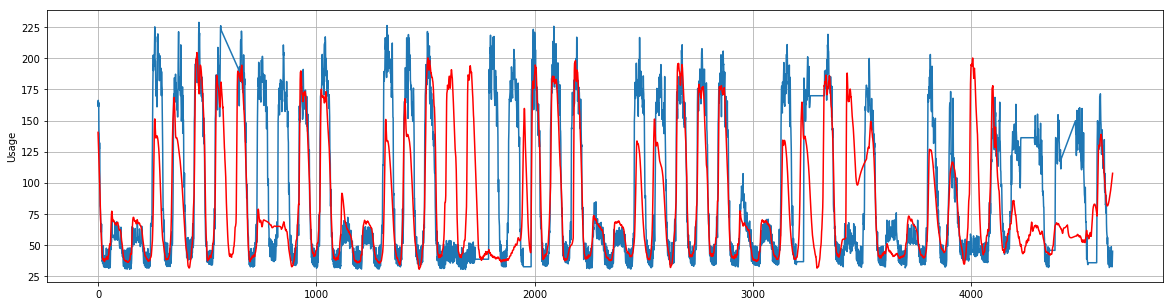

In [8]:
plt.rcParams["figure.figsize"] = (20,5)
plt.grid(True)
plt.ylabel('Usage')
plt.plot(y_test)
plt.plot(predictions,'r')
plt.show()    

In [13]:
from datetime import datetime, timedelta

dt_list = []
for i in range(len(test_set)-384):
    dt = datetime.strptime(test_set['datetime'].iloc[i],'%Y-%m-%d %H:%M:%S')
    dt_pred = dt + timedelta(minutes=15*192)
    dt_list.append(datetime.strftime(dt_pred,'%Y-%m-%d %H:%M:%S')[:-9])

In [ ]:
dt_li = [d for d in dt_list if ]

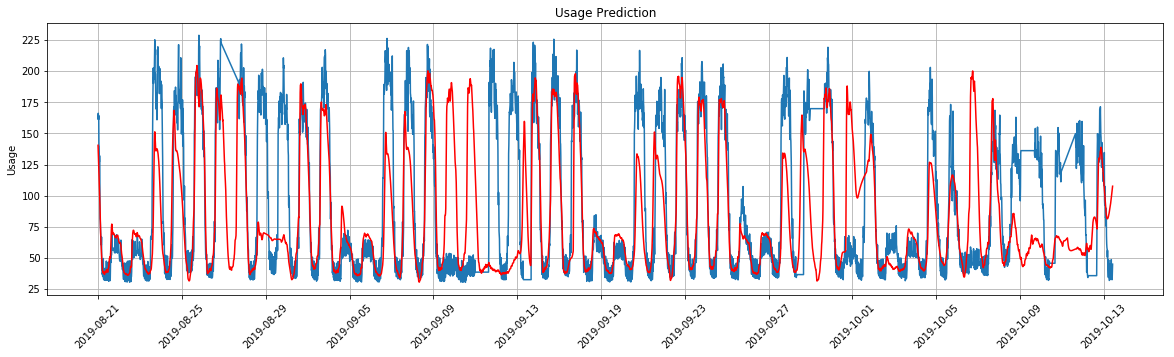

In [24]:
plt.rcParams["figure.figsize"] = (20,5)
plt.grid(True)

plt.ylabel('Usage')
plt.xticks(np.arange(0,len(y_test),step=384),labels=[dt_list[i] for i in range(0,len(dt_list), 384)], rotation=45)
plt.plot(y_test)
plt.plot(predictions,'r')
plt.title('Usage Prediction')
plt.show()  

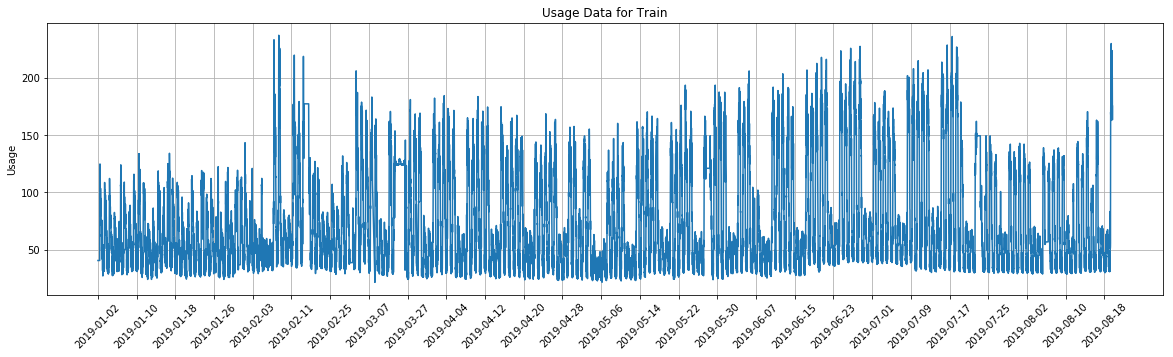

In [31]:
plt.rcParams["figure.figsize"] = (20,5)
plt.grid(True)

plt.ylabel('Usage')
plt.xticks(np.arange(0,len(train_set),step=768),labels=[train_set['datetime'][i][:-9] for i in range(0,len(train_set),768)], rotation=45)
plt.plot(train_set['usage'])
plt.title('Usage Data for Train')
plt.show()  